In [132]:
import pyham
from Bio import SeqIO
import os
import matplotlib.pyplot as plt
import networkx as nx

print(pyham.__version__, "   ", nx.__version__)

1.1.7     2.4


In [133]:
def locus_to_id(file):
    
    """
    This function extracts loci from a fasta file and store the information as keys in a dictionary 
    and the related protein ID as value.

    Args:
        file (:obj:`str`): path to the file of interest.

    Returns:
        a dictionary mapping the locus (:obj:`str`) with the protein ID (:obj:`str`).
    """
    
    locus_to_id = {}
    for seq_record in SeqIO.parse(file, 'fasta'):
        locus_to_id[seq_record.description.split('locus: ')[-1]] = seq_record.description
        
    return locus_to_id


def get_locus(directory):
    
    """
    This function goes through each file of a folder and build a dictionary containing loci 
    as keys and the related protein ID as values. For each entry in the dictionary, the function 
    updates the corresponding :obj:`pyham.abstractgene.Gene` by adding its locus.

    Args:
        directory (:obj:`str`): directory of interest.

    Returns:
        xxx
    """

    path = directory
    for file in os.listdir(path):
        ##print('File:', file)
        path_to_file = path + '/' + file
        locus_dictionary = locus_to_id(path_to_file)
 
        for (loci, gene_id) in locus_dictionary.items():
            gene = ham_analysis_no_name.get_genes_by_external_id(gene_id)
            
            # each gene should only map to 1 other gene, so should always be length 1...
            assert len(gene) == 1, 'gene_id maps to multiple entries'
            gene[0].locus = loci
            #for element in gene:
            #    element.locus = loci
                
        ham_analysis_no_name.get_extant_genome_by_name('.'.join(file.split('.')[:-1])).locus_assignment = True
        

def get_gene_by_locus(genome, locus):
    
    """
    Get a :obj:`pyham.abstractgene.Gene` that match the query locus. 

    Args:
        genome (:obj:`pyham.genome.Genome`): extant genome of interest.
        locus (:obj:`int`): locus.

    Returns:
        :obj:`pyham.abstractgene.Gene`.
    """
    
    for gene in genome.genes:
        if int(gene.locus) == locus:
            return gene 
    
    return None

def assign_neighbors(genome):
    
    """
    This function assigns neighbors to each :obj:`pyham.abstractgene.Gene` or :obj:`pyham.abstractgene.HOG`.

    Args:
        genome (:obj:`pyham.genome.Genome`): extant or ancestral genome of interest.

    Returns:
        xxx
    """
    
    if isinstance(genome, pyham.ExtantGenome):
        
        for extant_gene in genome.genes:
            extant_gene.neighbors = (get_gene_by_locus(genome, int(extant_gene.locus)-1), 
                                     get_gene_by_locus(genome, int(extant_gene.locus)+1))            
                        
    if isinstance(genome, pyham.AncestralGenome):
    
        for ancestral_gene in genome.genes:  
            
            # test here, see if does the same thing, children should only be direct descendants?
            #children = [child for child in ancestral_gene.children]
            children = ancestral_gene.children
            
            ######################################################################################
            # Dictionary containing genome names as keys (i.e. SE004) and a list of children as value #
            ######################################################################################
            
            genome_dict = {}  
            
            for child in children:
                if child.genome.name in genome_dict:
                    genome_dict[child.genome.name].append(child) # if already in dictionary, add it (duplicate)
                else:
                    genome_dict[child.genome.name] = [child] # otherwise add the child
            
            ############################################
            # Children are replaced by their neighbors #      
            ############################################
            
            for genome, gene_collection in genome_dict.items(): #stoca 
                for i in range(len(gene_collection)):
                    gene_collection[i] = list(gene_collection[i].neighbors)
            
            ################################################################################
            # Dictionary containing genomes as keys (i.e. SE004) and a list of parent HOGs #
            ################################################################################
            
            parent_dict = {} # gets a list of all potential neighboring hogs to the ancestral_gene
            for genome, neighbors_collection in genome_dict.items(): #stoca 
                for neighbors_pair in neighbors_collection:
                    for neighbor in neighbors_pair: # don't really need the for loop bc only ever 2 neighbors
                        if genome in parent_dict:   ## KJG - I don't understand this if/else - if we already put the focal genome in the parent dictionary, we do the same thing as if we didn't?
                            if neighbor == None:
                                parent_dict[genome].add(None)
                            else:
                                if neighbor.parent != ancestral_gene: #if theres' a duplication this might be true
                                    parent_dict[genome].add(neighbor.parent) #add the neighbors parents - the neighboring hogs
                        else:
                            if neighbor == None:
                                parent_dict[genome] = {None}    ## ah, this makes focal genome 'none' while above does 'add(None)' in addition to current genome?
                            else:
                                if neighbor.parent != ancestral_gene: # fill the parent dict by looking to see 
                                    parent_dict[genome] = {neighbor.parent}  ## again, no 'add', just make

            l = []  # List of sets
            for genome, parent in parent_dict.items():  
                l.append(parent)  # parent is a set
                ancestral_gene.list_parents = l            # List of potential neighbors in case of conflict
                
            final_neighbors = list(l[0].intersection(*l))  # Intersection of the sets
            
            if len(final_neighbors) == 2:
                ancestral_gene.neighbors = tuple(final_neighbors)
                print("fin", ancestral_gene.neighbors)
            
            elif len(final_neighbors) == 1:
                none_counter = 0
                potential_neighbor = None
                
                for collection in l:
                    if len(collection) == 2:
                        for element in collection:
                            if element == final_neighbors[0]:
                                continue
                            elif element == None:
                                none_counter += 1
                            else:
                                potential_neighbor = element
                
                    else:
                        break
                
                if none_counter == 1:  # To deal with missing orthology
                    final_neighbors.append(potential_neighbor)
                
                if len(final_neighbors) == 1:
                    final_neighbors.append(None)
                    ancestral_gene.neighbors = tuple(final_neighbors)
                else:  
                    ancestral_gene.neighbors = tuple(final_neighbors)
            
            elif len(final_neighbors) == 0 or len(final_neighbors) > 2:
                final_neighbors = [None, None]
                ancestral_gene.neighbors = tuple(final_neighbors)


In [222]:
# make an empty graph with possibility of multiple edges per node
G = nx.MultiGraph()
G.number_of_nodes()

0

In [223]:
G.number_of_edges()

0

## Graph Theory Approach

In [226]:
nwk_path = "working_perfect_3spp/RealTree.nwk"
#nwk_path = "comparable_loss/RealTree.nwk"
#nwk_path = "working_inversion_3spp/RealTree.nwk"

# The newick tree is extracted as a string
tree_str = pyham.utils.get_newick_string(nwk_path, type="nwk")

# Path to OrthoXML file
orthoxml_path = "working_perfect_3spp/Output/HierarchicalGroups.orthoxml"
#orthoxml_path = "comparable_loss/Output/HierarchicalGroups.orthoxml"
#orthoxml_path = "working_inversion_3spp/Output/HierarchicalGroups.orthoxml"

ham_analysis_no_name = pyham.Ham(tree_str, orthoxml_path, use_internal_name=False)

get_locus('working_perfect_3spp/DB')
#get_locus('comparable_loss/DB')
#get_locus('working_inversion_3spp/DB')

In [242]:
def make_synteny_graph(genome):
    
    """
    This function makes network graphs at the given level (genome) in the species tree.

    Args:
        genome (:obj:`pyham.genome.Genome`): extant or ancestral genome of interest.

    Returns:
        either a single graph for extant genes or multiple graphs for ancestral genes. 
        a graph for the HOGs and for each set of children from those HOGs at an ancestral node
    """
    
    if isinstance(genome, pyham.ExtantGenome):
        # make the graphs
        all_graphs = []
        extant_gene_graph = nx.Graph()
        parent_gene_graph = nx.Graph()
        ##extant_gene_graph = nx.MultiGraph() # only if I needed multiple edges for the same pair of nodes
        
        extant_gene_graph.add_node("start")
        parent_gene_graph.add_node("start")

        old_node = "start"
        old_parent_node = "start"
        for extant_gene in genome.genes:            
            new_node = (get_gene_by_locus(genome, int(extant_gene.locus)))
            new_parent_node = new_node.parent
                ##print(new_node, new_parent_node)
                ##print("extant", new_node)        
            
            # add the nodes to a graph
            extant_gene_graph.add_node(new_node)
            parent_gene_graph.add_node(new_parent_node)
                ##print("node.number", extant_gene_graph.number_of_nodes())
                ##print("old", old_node)
                ##print("nodes", extant_gene_graph.nodes)

            # create edges between the correct nodes
            extant_gene_graph.add_edge(old_node, new_node)
            parent_gene_graph.add_edge(old_parent_node, new_parent_node)
                ##print("edge.number", extant_gene_graph.number_of_edges())
                ##print("edges", extant_gene_graph.edges)

            # save the old node to create the next edge
            old_node = new_node
            old_parent_node = new_parent_node
        
        extant_gene_graph.remove_node("start") # remove it, was only there to make the edges as we went along
        parent_gene_graph.remove_node("start") # remove it, was only there to make the edges as we went along
        
        all_graphs.append(extant_gene_graph)
        all_graphs.append(parent_gene_graph)
        
        return(all_graphs)

    
    if isinstance(genome, pyham.AncestralGenome):
        # at an ancestral node, we build the graph based on the graphs at the descendant node
        # so for now just make all the vertices in the graph, and in another function, compare to descendant to connect edges
        
       # make the graphs
        all_graphs = []
        ancestral_gene_graph = nx.Graph()
        parent_gene_graph = nx.Graph()

#        ancestral_gene_graph = nx.Graph()
#        child1_gene_graph = nx.Graph()
#        child2_gene_graph = nx.Graph()

        # make a list of lists
        #     - a parent graph
        #     - a graph for each set of children (maybe more than 2 children if polytomies?)
#        all_graphs = []
#        hog_list = []
#        child1_list = []
#        child2_list = []        
        
        for ancestral_gene in genome.genes:
            ancestral_gene_graph.add_node(ancestral_gene)
            #if ancestral_gene.parent == None:
            #    print("no parent HOG")
            parent_gene_graph.add_node(ancestral_gene.parent)
#            child1_gene_graph.add_node(ancestral_gene.children[0])
#            child2_gene_graph.add_node(ancestral_gene.children[1])

#            hog_list.append(ancestral_gene)
#            child1_list.append(ancestral_gene.children[0])
#            child2_list.append(ancestral_gene.children[1])
            if len(ancestral_gene.children) > 2:
                print("fix problem, there is a polytomy")
            
        # make a graph from the list of nodes, complete graph makes edges between all nodes
#        ancestral_gene_graph = nx.complete_graph(hog_list)     
#        child1_gene_graph = nx.complete_graph(child1_list)     
#        child2_gene_graph = nx.complete_graph(child2_list)
        
        all_graphs.append(ancestral_gene_graph)
        all_graphs.append(parent_gene_graph)
#        all_graphs.append(child2_gene_graph)
        
        return(all_graphs)

In [243]:
def compare_synteny_graphs(tree_node):
    
    """
    This function compares network graphs at the given level (genome) in the species tree to its descendant graphs.

    Args:
        genome (:obj:`pyham.genome.Genome`): ancestral genome of interest.

    Returns:
        either a single graph for extant genes or multiple graphs for ancestral genes. 
    """
    
    if isinstance(tree_node.genome, pyham.ExtantGenome):
        print("synteny already assigned for extant genome")
        
    if isinstance(tree_node.genome, pyham.AncestralGenome):
#        print("ancestor", tree_node.graph[0].nodes)
#        print("ancestor.parent", tree_node.graph[1].nodes)
        print("find synteny")
        
        # take this tree node
        # get the descendant tree nodes (and their parent graphs)
        descendants = tree_node.name.split("/")
        if len(descendants) > 2:
            print("need to fix this problem")
        descendant1 = ham_analysis_no_name.get_extant_genome_by_name(descendants[0])
        descendant2 = ham_analysis_no_name.get_extant_genome_by_name(descendants[1])
        print("desc 1", descendant1.graph[1].nodes)
        print("desc 1", descendant1.graph[1].edges)
        
        tree_node.graph[0].number_of_edges()
        # compare the synteny of this graph (0) to the parent graph of the descendants (1)
        # makes two graphs at this level
        # merge the graphs where no conflict
        # leave conflicting edges in as both, and settle them where possible

    #gene2 = ham_analysis_no_name.get_extant_genome_by_name("SE002_aa")
    #hog = ham_analysis_no_name.get_ancestral_genome_by_name("SE002_aa/SE003_aa")
    #print(hog.graph)
        #R.remove_nodes_from(n for n in G if n not in H)
        
# Then you get the corresponding mrca ancestral genomes 
#genome_rodents_3 = ham_analysis.get_ancestral_genome_by_mrca_of_genome_set({genome_rat, genome_mouse})
        



--SE001_aa

--SE002_aa

--SE003_aa

   /-SE002_aa
--|
   \-SE003_aa

   /-SE001_aa
--|
  |   /-SE002_aa
   \-|
      \-SE003_aa


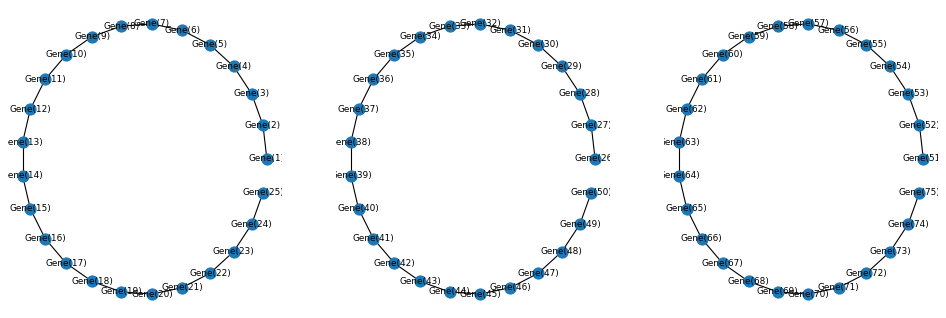

In [248]:
fig=plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
# make the first round of graphs at all nodes

plot_loc = 131
for tree_node in ham_analysis_no_name.taxonomy.tree.traverse('postorder'):
    print(tree_node)
    tree_node.graph = make_synteny_graph(tree_node.genome)

    if isinstance(tree_node.genome, pyham.ExtantGenome):
        #print("extant synteny", tree_node.graph[0].edges)
        plt.subplot(plot_loc)
        nx.draw(tree_node.graph[0], with_labels=True, font_weight='normal', font_size=8, node_size=100,
                pos=nx.circular_layout(tree_node.graph[0]))
#        plt.subplot(plot_loc+3)
#        nx.draw(tree_node.graph[1], with_labels=True, font_weight='normal', node_size=100, 
#                pos=nx.circular_layout(tree_node.graph[1]), node_color='r', edge_color='b')
        plot_loc += 1

        
 
# go back through internal nodes to assign synteny based on what was already known at the leaf nodes
#for tree_node in ham_analysis_no_name.taxonomy.internal_nodes: 
#   NEED TO BE SURE IT ALWAYS GOES IN POSTORDER? - it doesn't , figure this out but for now go by below
#    print(tree_node)
#    print(tree_node.genome)
#ham_analysis_no_name.taxonomy.internal_nodes
 

num initial nodes 25
num initial edges 0
num nodes after adding 25
num edges after adding 24


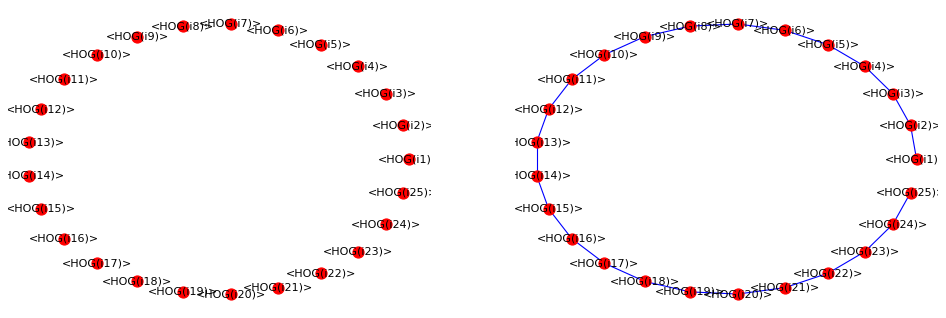

In [249]:
fig=plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')

## MANUALLY ?? do the internal nodes for now

tree_node = ham_analysis_no_name.get_ancestral_genome_by_name("SE002_aa/SE003_aa")
descendants = tree_node.name.split("/")

plt.subplot(121)
nx.draw(tree_node.taxon.graph[0], with_labels=True, font_weight='normal', font_size=10, node_size=100, 
        pos=nx.circular_layout(tree_node.taxon.graph[0]), node_color='r', edge_color='b')

# must be an easier way to see the descendant nodes?

descendant1 = ham_analysis_no_name.get_extant_genome_by_name(descendants[0])
descendant2 = ham_analysis_no_name.get_extant_genome_by_name(descendants[1])

##print("desc1", descendant1.taxon.graph[0].edges)
##print("desc1", descendant1.taxon.graph[1].edges)
##print("desc2", descendant2.taxon.graph[0].edges)
##print("desc2", descendant2.taxon.graph[1].edges)

print("num initial nodes", tree_node.taxon.graph[0].number_of_nodes())
print("num initial edges", tree_node.taxon.graph[0].number_of_edges())

# add edges from descendant1
tree_node.taxon.graph[0].add_edges_from(descendant1.taxon.graph[1].edges)
# add edges from descendant2
tree_node.taxon.graph[0].add_edges_from(descendant2.taxon.graph[1].edges)

print("num nodes after adding", tree_node.taxon.graph[0].number_of_nodes())
print("num edges after adding", tree_node.taxon.graph[0].number_of_edges())
##print(tree_node.taxon.graph[0].edges)

plt.subplot(122)
nx.draw(tree_node.taxon.graph[0], with_labels=True, font_weight='normal', font_size=10, node_size=100, 
        pos=nx.circular_layout(tree_node.taxon.graph[0]), node_color='r', edge_color='b')

num initial nodes 25
num initial edges 0
num nodes after adding 25
num edges after adding 24


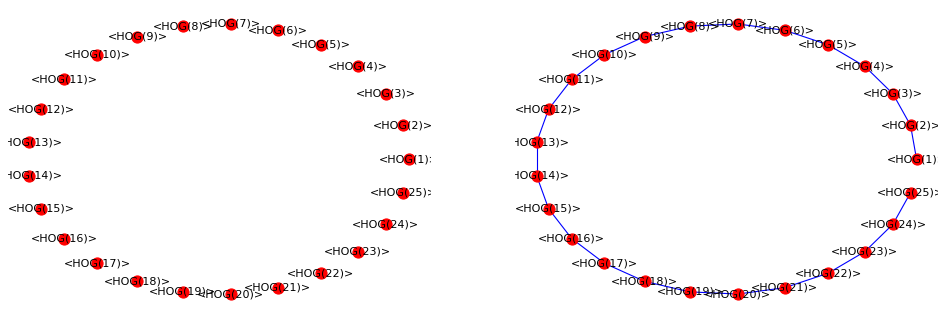

In [251]:
# GO TO THE TOPMOST NODE, MANUALLY
# must be an easier way to see the descendant nodes?

fig=plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')

## MANUALLY ?? do the internal nodes for now

tree_node = ham_analysis_no_name.get_ancestral_genome_by_name("SE001_aa/SE002_aa/SE003_aa")
desc1 = "SE001_aa"
desc2 = "SE002_aa/SE003_aa"

plt.subplot(121)
nx.draw(tree_node.taxon.graph[0], with_labels=True, font_weight='normal', font_size=10, node_size=100, 
        pos=nx.circular_layout(tree_node.taxon.graph[0]), node_color='r', edge_color='b')

# must be an easier way to see the descendant nodes?

descendant1 = ham_analysis_no_name.get_extant_genome_by_name(desc1)
descendant2 = ham_analysis_no_name.get_ancestral_genome_by_name(desc2)

##print("desc1", descendant1.taxon.graph[0].edges)
##print("desc1", descendant1.taxon.graph[1].edges)
##print("desc2", descendant2.taxon.graph[0].edges)
##print("desc2", descendant2.taxon.graph[1].edges)

print("num initial nodes", tree_node.taxon.graph[0].number_of_nodes())
print("num initial edges", tree_node.taxon.graph[0].number_of_edges())

# add edges from descendant1
tree_node.taxon.graph[0].add_edges_from(descendant1.taxon.graph[1].edges)
# add edges from descendant2
tree_node.taxon.graph[0].add_edges_from(descendant2.taxon.graph[1].edges)

print("num nodes after adding", tree_node.taxon.graph[0].number_of_nodes())
print("num edges after adding", tree_node.taxon.graph[0].number_of_edges())
##print(tree_node.taxon.graph[0].edges)

plt.subplot(122)
nx.draw(tree_node.taxon.graph[0], with_labels=True, font_weight='normal', font_size=10, node_size=100, 
        pos=nx.circular_layout(tree_node.taxon.graph[0]), node_color='r', edge_color='b')

In [ ]:
tree_node = ham_analysis_no_name.get_ancestral_genome_by_name("SE002_aa/SE003_aa")
descendants = tree_node.name.split("/")

#plt.subplot(121)
nx.draw(tree_node.taxon.graph[0], with_labels=True, font_weight='normal', node_size=100, 
        pos=nx.circular_layout(tree_node.taxon.graph[0]), node_color='r', edge_color='b')

In [ ]:

for tree_node in ham_analysis_no_name.taxonomy.tree.traverse('postorder'):
#    compare_synteny_graphs(tree_node)    
    print(tree_node)
    if isinstance(tree_node.genome, pyham.ExtantGenome):
        print("synteny already assigned for extant genome")
        
    if isinstance(tree_node.genome, pyham.AncestralGenome):
#        print("ancestor", tree_node.graph[0].nodes)
#        print("ancestor.parent", tree_node.graph[1].nodes)
        print("find synteny")
        
        # take this tree node
        # get the descendant tree nodes (and their parent graphs)
        descendants = tree_node.name.split("/")
        if len(descendants) > 2:
            print("need to fix this problem")
        descendant1 = ham_analysis_no_name.get_extant_genome_by_name(descendants[0])
        descendant2 = ham_analysis_no_name.get_extant_genome_by_name(descendants[1])
        #print(descendant1, descendant2)
        #print("desc 1 edges", descendant1.taxon.graph[1].edges)
        
#        test = descendant1.taxon.graph[1].copy()
#        test.remove_nodes_from(n for n in descendant1.taxon.graph[1] if n not in descendant2.taxon.graph[1])
        
        print("num initial nodes", tree_node.graph[0].number_of_nodes())
        print("num initial edges", tree_node.graph[0].number_of_edges())
        
        # add edges from descendant1
        tree_node.graph[0].add_edges_from(descendant1.taxon.graph[1].edges)
        # add edges from descendant2
        tree_node.graph[0].add_edges_from(descendant2.taxon.graph[1].edges)
        
        print("num nodes after adding", tree_node.graph[0].number_of_nodes())
        print("num edges after adding", tree_node.graph[0].number_of_edges())
        print(tree_node.graph[0].edges)
        
        #nx.draw(tree_node.graph[0], with_labels=True, font_weight='normal', node_size=100, 
         #       pos=nx.circular_layout(tree_node.graph[1]), node_color='r', edge_color='b')
        # compare the synteny of this graph (0) to the parent graph of the descendants (1)
        # makes two graphs at this level
        # merge the graphs where no conflict
        # leave conflicting edges in as both, and settle them where possible

    #gene2 = ham_analysis_no_name.get_extant_genome_by_name("SE002_aa")
    #hog = ham_analysis_no_name.get_ancestral_genome_by_name("SE002_aa/SE003_aa")

        
# Then you get the corresponding mrca ancestral genomes 
#genome_rodents_3 = ham_analysis.get_ancestral_genome_by_mrca_of_genome_set({genome_rat, genome_mouse})
       

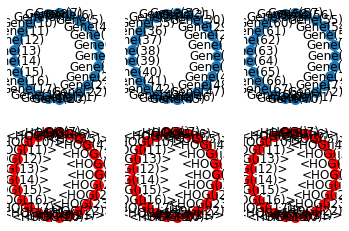

In [179]:
## test initial graphs

plot_loc = 231
for tree_node in ham_analysis_no_name.taxonomy.tree.traverse('postorder'):
# graphs made above    ##tree_node.graph = make_synteny_graph(tree_node.genome)
    if isinstance(tree_node.genome, pyham.ExtantGenome):
        plt.subplot(plot_loc)
        nx.draw(tree_node.graph[0], with_labels=True, font_weight='normal', node_size=100,
                pos=nx.circular_layout(tree_node.graph[0]))#, label="extant network", nlist=[range(5, 10), range(5)])
        #nx.draw(tree_node.graph[1], with_labels=True, font_weight='bold')
        plt.subplot(plot_loc+3)
        nx.draw(tree_node.graph[1], with_labels=True, font_weight='normal', node_size=100, 
                pos=nx.circular_layout(tree_node.graph[1]), node_color='r', edge_color='b')

        plot_loc += 1

    
    
#    if isinstance(tree_node.genome, pyham.ExtantGenome): # then we already have the synteny and all is good
#        print(tree_node.graph.nodes)
#        print("nodes", tree_node.graph.number_of_nodes())
#        print("edges", tree_node.graph.number_of_edges())
        
#    if isinstance(tree_node.genome, pyham.AncestralGenome): # then we want to compare to assign the proper synteny
#        print("ancestor", tree_node.graph[0].nodes)
#        print("ancestor", tree_node.graph[1].nodes)
#        print("ancestor", tree_node.graph[2].nodes)
#        print("nodes", tree_node.graph[0].number_of_nodes())
#        print("edges", tree_node.graph[0].number_of_edges())

##print(ham_analysis_no_name.taxonomy.internal_nodes)
##print(ham_analysis_no_name.taxonomy.leaves)

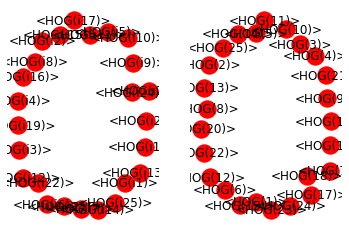

In [156]:
# CURRRENT (ancestral) NETWORK
plt.subplot(121)

test = ham_analysis_no_name.get_ancestral_genome_by_name("SE002_aa/SE003_aa")
#print(test.taxon.graph)
##vars(test) # show all call-able attributes

nx.draw(test.taxon.graph[0], with_labels=True, font_weight='normal', 
        node_color='r', edge_color='b') # pos=nx.circular_layout(G),

## PARENT NETWORK
plt.subplot(122)

test = ham_analysis_no_name.get_ancestral_genome_by_name("SE002_aa/SE003_aa")

nx.draw(test.taxon.graph[1], with_labels=True, font_weight='normal', 
        node_color='r', edge_color='b') # pos=nx.circular_layout(G),

In [157]:
vars(test)

{'genes': [<HOG(i1)>,
  <HOG(i2)>,
  <HOG(i3)>,
  <HOG(i4)>,
  <HOG(i5)>,
  <HOG(i6)>,
  <HOG(i7)>,
  <HOG(i8)>,
  <HOG(i9)>,
  <HOG(i10)>,
  <HOG(i11)>,
  <HOG(i12)>,
  <HOG(i13)>,
  <HOG(i14)>,
  <HOG(i15)>,
  <HOG(i16)>,
  <HOG(i17)>,
  <HOG(i18)>,
  <HOG(i19)>,
  <HOG(i20)>,
  <HOG(i21)>,
  <HOG(i22)>,
  <HOG(i23)>,
  <HOG(i24)>,
  <HOG(i25)>],
 'taxon': Tree node 'SE002_aa/SE003_aa' (0x11d3b0b5),
 'name': 'SE002_aa/SE003_aa',
 'ancestral_clustering': None}

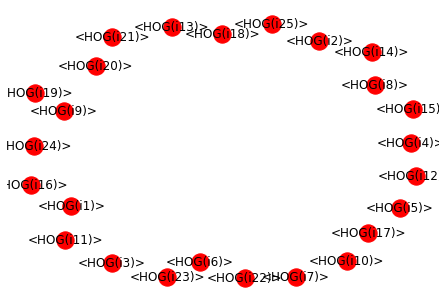

In [147]:
## PARENT NETWORK

test = ham_analysis_no_name.get_ancestral_genome_by_name("SE002_aa/SE003_aa")

nx.draw(test.taxon.graph[0], with_labels=True, font_weight='normal', 
        node_color='r', edge_color='b') # pos=nx.circular_layout(G),


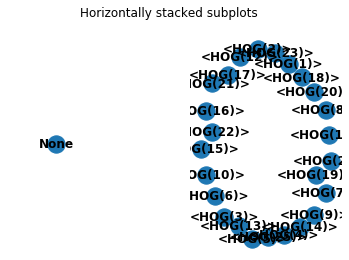

In [145]:
test = ham_analysis_no_name.get_ancestral_genome_by_name("SE001_aa/SE002_aa/SE003_aa")

fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('Horizontally stacked subplots')

nx.draw(test.taxon.graph[0], with_labels=True, font_weight='bold')
plt.subplot(131)

nx.draw(test.taxon.graph[1], with_labels=True, font_weight='bold')
#plt.subplot(122)
#nx.draw(test.taxon.graph[2], with_labels=True, font_weight='bold')
#plt.subplot(121)


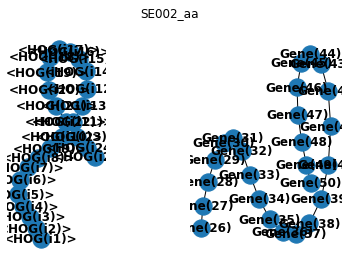

In [146]:
test = ham_analysis_no_name.get_extant_genome_by_name("SE002_aa")

fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('SE002_aa')

nx.draw(test.taxon.graph[0], with_labels=True, font_weight='bold')
plt.subplot(131)

nx.draw(test.taxon.graph[1], with_labels=True, font_weight='bold')
#plt.subplot(122)
#nx.draw(test.taxon.graph[2], with_labels=True, font_weight='bold')
#plt.subplot(121)